# Convolutional Neural Network (CNN)

A **Convolutional Neural Network (CNN)** is a type of neural network designed to handle **grid-like data**, most commonly **images**, but also audio or video. CNNs are especially good at recognizing **spatial patterns** like edges, textures, and shapes.

## 1. Key Idea
- Uses **convolutional layers** that scan input with **small filters (kernels)**.
- Filters **slide across the input** and detect patterns like lines, curves, or textures.
- Automatically learns **which features are important** for tasks like image classification.

## 2. Structure
### Convolutional Layer (Conv)
- Applies multiple filters to the input.
- Each filter produces a **feature map** showing where certain patterns appear.
- Example: A filter detecting vertical edges highlights vertical lines in an image.

### Activation Function (e.g., ReLU)
- Adds non-linearity, allowing the network to learn complex patterns.

### Pooling Layer (e.g., Max Pooling)
- Reduces the spatial size of feature maps.
- Keeps the most important information while reducing computation.
- Example: Max pooling picks the maximum value in a small region.

### Fully Connected Layer
- After several convolution + pooling layers, features are flattened and fed into fully connected layers for classification or regression.

## 3. How it Works
1. Input: 28x28 pixels grayscale image.
2. Convolution: Apply multiple 3x3 filters → produce feature maps.
3. ReLU: Make output non-linear.
4. Pooling: Downsample the feature maps.
5. Flatten → Fully Connected → Output probabilities for classes (e.g., digits 0–9).

## 4. Advantages
- **Parameter sharing:** Same filter is used across the input → fewer weights than fully connected layers.
- **Translation invariance:** Can recognize patterns even if shifted slightly in the image.
- **Hierarchical feature learning:** Early layers learn edges, later layers learn shapes, and final layers learn object-level features.

## 5. Visualization
```
Input Image (28x28)
       │
  [Conv 3x3 + ReLU] → Feature Map
       │
     [Pooling] → Downsampled Feature Map
       │
  [Conv 3x3 + ReLU] → More Complex Features
       │
     [Pooling] → Flatten
       │
  [Fully Connected Layer] → Output Classes
```





## A Demo
This demo is to classify images from CIFAR-10 dataset. CIFAR-10 dataset has 10 different class of images.

In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch._C import device
from torch.utils.data import Dataset, DataLoader

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------------------------------------------------
# Hyperparameters
# -------------------------------------------------------------
input_size = 1024 # Because input CIFAR10 images are of 32 x 32 pixels
hidden_size = 128 # hidden layer neurons
num_classes = 10 # 10 different hand-written digits in MINST (0...9)
num_epochs = 4
batch_size = 4
learning_rate = 0.001

In [9]:
# Load dataset
# Data augmentation + normalization for training set
# mean (0.4914, 0.4822, 0.4465) and std=(0.2470, 0.2435, 0.2616) are the industry standard mean & std for RGB channels
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),     # Randomly crop to 32x32 with padding
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally
    transforms.ToTensor(),                    # Convert from [0,255] → [0.0,1.0]
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),        # Channel-wise mean (R,G,B)
        std=(0.2470, 0.2435, 0.2616)          # Channel-wise std (R,G,B)
    ),
])

# Only normalization for test/validation set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    ),
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

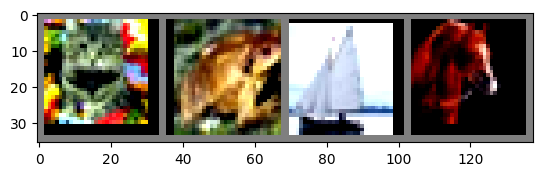

cat   frog  ship  horse


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# =============================================================
# Convolutional Neural Network (CNN) for CIFAR-10
# =============================================================
# CIFAR-10 images: 32x32 pixels, 3 channels (RGB)
# CNN preserves spatial structure and learns hierarchical features
# =============================================================

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()

        # -------------------------
        # CONVOLUTIONAL BLOCK 1
        # -------------------------
        # Input: (B, 3, 32, 32)
        # Conv2d:
        #   in_channels = 3 (RGB)
        #   out_channels = 32 → number of filters → produces 32 feature maps
        #   kernel_size = 3 → size of each filter (3x3)
        #   padding = 1 → keeps spatial size same (32x32)
        # Output after conv: (B, 32, 32, 32)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # preserves shape: (B, 32, 32, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample → (B, 32, 16, 16)

        # -------------------------
        # CONVOLUTIONAL BLOCK 2
        # -------------------------
        # Input: (B, 32, 16, 16)
        # Conv2d:
        #   in_channels = 32
        #   out_channels = 64 → number of filters → produces 64 feature maps
        #   kernel_size = 3 → 3x3 filters
        #   padding = 1 → spatial size preserved (16x16)
        # Output after conv: (B, 64, 16, 16)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # preserves shape: (B, 64, 16, 16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample → (B, 64, 8, 8)

        # -------------------------
        # CONVOLUTIONAL BLOCK 3
        # -------------------------
        # Input: (B, 64, 8, 8)
        # Conv2d:
        #   in_channels = 64
        #   out_channels = 128 → number of filters → produces 128 feature maps
        #   kernel_size = 3 → 3x3 filters
        #   padding = 1 → spatial size preserved (8x8)
        # Output after conv: (B, 128, 8, 8)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # preserves shape: (B, 128, 8, 8)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample → (B, 128, 4, 4)

        # -------------------------
        # FULLY CONNECTED LAYERS
        # -------------------------
        # Flatten (B, 128, 4, 4) → (B, 128*4*4 = 2048)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Output: (B, 256)
        self.fc2 = nn.Linear(256, num_classes)  # Output: (B, 10)

    def forward(self, x):
        # -------------------------
        # Forward pass
        # -------------------------
        x = F.relu(self.bn1(self.conv1(x)))  # Conv1 + BN + ReLU → (B, 32, 32, 32)
        x = self.pool1(x)                    # MaxPool1 → (B, 32, 16, 16)

        x = F.relu(self.bn2(self.conv2(x)))  # Conv2 + BN + ReLU → (B, 64, 16, 16)
        x = self.pool2(x)                    # MaxPool2 → (B, 64, 8, 8)

        x = F.relu(self.bn3(self.conv3(x)))  # Conv3 + BN + ReLU → (B, 128, 8, 8)
        x = self.pool3(x)                    # MaxPool3 → (B, 128, 4, 4)

        # Flatten feature maps to 1D vector → (B, 2048)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))  # (B, 256)
        x = self.fc2(x)          # (B, 10) → logits for 10 classes
        return x


# =============================================================
# Model setup
# =============================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 10
learning_rate = 0.001
num_epochs = 10

model = ConvNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# =============================================================
# Training loop
# =============================================================
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")


# =============================================================
# Evaluation loop
# =============================================================
model.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predictions == labels).sum().item()

    accuracy = 100 * n_correct / n_samples
    print(f'Accuracy on CIFAR-10 test images: {accuracy:.2f}%')


Epoch [1/10], Step [100/12500], Loss: 2.3873
Epoch [1/10], Step [200/12500], Loss: 2.0541
Epoch [1/10], Step [300/12500], Loss: 1.9906
Epoch [1/10], Step [400/12500], Loss: 1.6782
Epoch [1/10], Step [500/12500], Loss: 2.0611
Epoch [1/10], Step [600/12500], Loss: 2.0586
Epoch [1/10], Step [700/12500], Loss: 1.4399
Epoch [1/10], Step [800/12500], Loss: 1.7331
Epoch [1/10], Step [900/12500], Loss: 1.8004
Epoch [1/10], Step [1000/12500], Loss: 1.1341
Epoch [1/10], Step [1100/12500], Loss: 1.7960
Epoch [1/10], Step [1200/12500], Loss: 1.4527
Epoch [1/10], Step [1300/12500], Loss: 1.6482
Epoch [1/10], Step [1400/12500], Loss: 2.6435
Epoch [1/10], Step [1500/12500], Loss: 1.7688
Epoch [1/10], Step [1600/12500], Loss: 1.6700
Epoch [1/10], Step [1700/12500], Loss: 0.9796
Epoch [1/10], Step [1800/12500], Loss: 1.9316
Epoch [1/10], Step [1900/12500], Loss: 1.5131
Epoch [1/10], Step [2000/12500], Loss: 1.2306
Epoch [1/10], Step [2100/12500], Loss: 1.0011
Epoch [1/10], Step [2200/12500], Loss: 1.48